In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
img_path = "/mnt/storage_4tb/ymi/geo_data/angle_net_data/dist_maps_train/1-61/masks/24_19764_23058_6588_9882.png"

In [3]:
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

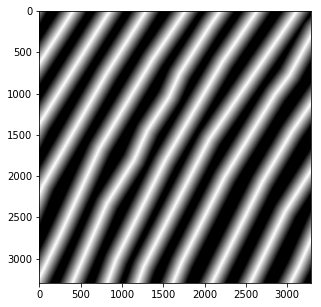

In [4]:
plt.figure(figsize=(5,5))
plt.imshow(img, "gray")

(Text(0.5,1,'Sobel abs(CV_64F)'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

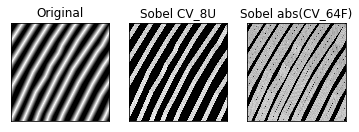

In [5]:
# Output dtype = cv.CV_8U
sobelx8u = cv2.Sobel(img,cv2.CV_8U,1,0,ksize=5)
# Output dtype = cv.CV_64F. Then take its absolute and convert to cv.CV_8U
sobelx64f = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
abs_sobel64f = np.absolute(sobelx64f)
sobel_8u = np.uint8(abs_sobel64f)
plt.subplot(1,3,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(sobelx8u,cmap = 'gray')
plt.title('Sobel CV_8U'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(sobel_8u,cmap = 'gray')
plt.title('Sobel abs(CV_64F)'), plt.xticks([]), plt.yticks([])
# plt.show()

In [6]:
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

abs_sobelx = np.absolute(sobelx)
abs_sobely = np.absolute(sobely)

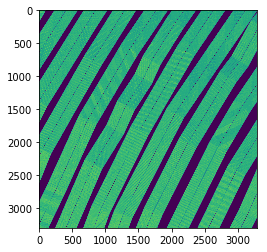

In [7]:
plt.imshow(abs_sobelx)

In [8]:
from numba import jit
import numpy as np

#x = np.arange(100).reshape(10, 10)

@jit(nopython=True)
def calculate_gradient_angle(x_grad, y_grad):
    res_arr = np.zeros(x_grad.shape)
#     flatten_map = dist_map.flatten()
    for i in np.arange(x_grad.shape[0]):
        for j in np.arange(x_grad.shape[1]):
            res_arr[i, j] = np.arctan2(x_grad[i, j], y_grad[i, j])

    return res_arr


In [9]:
grad_angle = calculate_gradient_angle(abs_sobelx, abs_sobely)

In [ ]:
grad_angle = np.arctan2(abs_sobely, abs_sobelx) * 180 / np.pi

In [ ]:
angle = np.mean(grad_angle[grad_angle > 0])

In [ ]:
laplaccian_filter = np.array([[0, 0, 0],
                             [-1, 8, -1],
                             [0, 0, 0]], dtype=np.float32)

In [ ]:
laplaccian_filter

In [ ]:
M = cv2.getRotationMatrix2D((1, 1), 21, 1)

In [ ]:

dst = cv2.warpAffine(laplaccian_filter, M,(3,3))

In [ ]:
filtered_img = cv2.filter2D(img, cv2.CV_32F, dst)

In [ ]:
plt.imshow(filtered_img)

In [ ]:
plt.imshow(laplaccian_filter)

In [8]:
import skimage
print(skimage.__version__)

0.15.0


In [9]:
from skimage.morphology import skeletonize
import numpy as np
# print(np.__version__)

In [10]:
def get_laplacian_filter(img):
#     print(img.max())
#     img[img > 50] = 1
    img[img < 49] = 0
    img[img >= 49] = 1
    kernel = np.ones((3,3))
    
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
#     img = skeletonize(img)
#     img = img.astype(np.uint8)
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=31)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=31)

#     sobelx = np.absolute(sobelx)
#     sobely = np.absolute(sobely)
#     grad_angle = np.arctan2(sobely, sobelx) * 180 / np.pi + 180
#     angle = np.mean(grad_angle[grad_angle > 0])
#     print(angle)
#     mask = (sobelx == 0) & (sobely == 0)
    grad_angle = cv2.phase(sobelx,sobely,angleInDegrees=True)
    grad_angle[grad_angle > 180] = grad_angle[grad_angle > 180] - 180
#     grad_angle = 180 - grad_angle
    angle_calc = grad_angle[grad_angle > 0]
    
#     std = np.std(angle_calc)
#     mean = np.mean(angle_calc)
#     cv = std/mean
# #     print("Mean: {}, Std: {}, CV: {}".format(mean, std, cv))
#     if cv > 0.5:
#         angle_calc[(angle_calc < 10) & (angle_calc > 0)] = 180
#         angle = np.percentile(angle_calc, 60)
    angle = np.mean(angle_calc)#  + 90
#     if angle > 180:
#         angle = angle - 180
    result_angle = np.full_like(img, angle)
    laplaccian_filter = np.array([[0, 0, 0],
                                     [-1, 8, -1],
                                     [0, 0, 0]], dtype=np.float32)
    
    M = cv2.getRotationMatrix2D((1, 1), angle, 1)
    rotated_filter = cv2.warpAffine(laplaccian_filter, M, (3,3))
    return rotated_filter, grad_angle, result_angle

In [11]:
angle = 162
result_angle = np.full_like(img, angle)
laplaccian_filter = np.array([[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]], dtype=np.float32)

M = cv2.getRotationMatrix2D((1, 1), angle, 1)
rotated_filter = cv2.warpAffine(laplaccian_filter, M, (3,3))

In [12]:
rotated_filter

array([[ 1.0078125 ,  0.33203125, -0.4921875 ],
       [ 1.5820312 ,  0.        , -1.5820312 ],
       [ 0.4921875 , -0.33203125, -1.0078125 ]], dtype=float32)

In [13]:
rotated_filter

array([[ 1.0078125 ,  0.33203125, -0.4921875 ],
       [ 1.5820312 ,  0.        , -1.5820312 ],
       [ 0.4921875 , -0.33203125, -1.0078125 ]], dtype=float32)

In [11]:
raster_path = "/mnt/storage_4tb/ymi/geo_data/angle_net_data/rio_grande/58809/dist_net_1349_256/project_transparent_mosaic_rgb_bin.tif"
save_path = "/mnt/storage_4tb/ymi/geo_data/angle_net_data/rio_grande/58809/dist_net_1349_256/project_transparent_mosaic_rgb_mean.tif"
save_images_dir = "/mnt/storage_4tb/ymi/geo_data/angle_net_data/rio_grande/58809/dist_net_1349_256/images"
os.makedirs(save_images_dir, exist_ok=True)

In [12]:
import rasterio
from tqdm import tqdm_notebook

In [13]:
window_size = 30
cnt = 0
with rasterio.open(raster_path, 'r') as dataset:
    meta = dataset.meta
    raster_array = np.zeros((3, dataset.meta['height'], dataset.meta['width']), np.uint8)
    xs = dataset.bounds.left
    window_size_meters = window_size
    window_size_pixels = window_size / (dataset.res[0])
    cnt = 0
    pbar = tqdm_notebook()
    while xs < dataset.bounds.right:
        ys = dataset.bounds.bottom
        while ys < dataset.bounds.top:
            row, col = dataset.index(xs, ys)
            
            step_row = row - int(window_size_pixels)
            step_col = col + int(window_size_pixels)
            res = dataset.read(window=((max(0, step_row), row),
                                       (col, step_col)), indexes=1)
            rect = [[max(0, step_row), row], [col, step_col]]
            laplacian_filter, grad_angle, result_angle = get_laplacian_filter(res.copy())
#             if laplacian_filter[0, 0] != 0:
#                 print(laplacian_filter)
# #             if not np.isnan(angle):
#                 print(angle)
#                 print(res.max())
            save_img_path = os.path.join(save_images_dir, str(cnt) + '.png')
            cv2.imwrite(save_img_path, res)
            filtered_img = cv2.filter2D(res, cv2.CV_32F, laplacian_filter)
            filtered_img[filtered_img < 0] =0
            filtered_img = (filtered_img / 8).astype(np.uint8)
#             filtered_img = angles.astype(np.uint8)
            raster_array[0, rect[0][0]:rect[0][1], rect[1][0]:rect[1][1]] = filtered_img
            raster_array[1, rect[0][0]:rect[0][1], rect[1][0]:rect[1][1]] = grad_angle
            raster_array[2, rect[0][0]:rect[0][1], rect[1][0]:rect[1][1]] = result_angle
            # raster_array[rect[0][0]:rect[0][1], rect[1][0]:rect[1][1]] = np.mean(stack_arr, axis=2)

            pbar.update(1)
            pbar.set_postfix(Row='{}'.format(row), Col='{}'.format(col))
#             pbar.set_postfix(angle=angle, max_val=res.max())
            cnt += 1
            ys = ys + window_size_meters

        xs = xs + window_size_meters

save_meta = meta.copy()
save_meta.update({"count": 3})
with rasterio.open(save_path, "w", **save_meta) as dst:
    for i in range(3):
        dst.write(raster_array[i], i+1)

/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [43]:
save_meta = meta.copy()
save_meta.update({"count": 3})
with rasterio.open(save_path, "w", **save_meta) as dst:
    for i in range(3):
        dst.write(raster_array[i], i+1)

In [18]:
angle

162

In [91]:
res = cv2.imread("/mnt/storage_4tb/ymi/geo_data/angle_net_data/rio_grande/58809/dist_net_1349_256/images/214.png", cv2.IMREAD_GRAYSCALE)

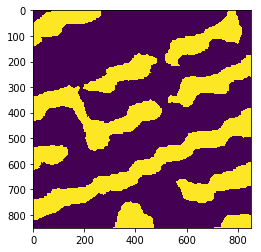

In [92]:
plt.imshow(res > 49)

In [93]:
skelet = skeletonize(res > 49)
skelet = (skelet * 255).astype(np.uint8)
sobelx = cv2.Sobel(skelet,cv2.CV_64F,1,0,ksize=3)
sobely = cv2.Sobel(skelet,cv2.CV_64F,0,1,ksize=3)

grad_angle = cv2.phase(sobelx,sobely,angleInDegrees=True)
grad_angle[grad_angle > 180] = grad_angle[grad_angle > 180] - 180

# angle_calc = grad_angle[grad_angle > 0]
unique, counts = np.unique(grad_angle[grad_angle> 0].flatten().astype(np.uint8), return_counts=True)

angle = unique[np.argmax(counts)]
# angle = np.mean(angle_calc)
laplaccian_filter = np.array([[1, -1, 1, -1, 1],
                              [1, -1, 1, -1, 1],
                              [1, -1, 1, -1, 1],
                              [1, -1, 1, -1, 1],
                              [1, -1, 1, -1, 1]], dtype=np.float32)

# laplaccian_filter = np.array([[0, 0, 0],
#                                      [-1, 8, -1],
#                                      [0, 0, 0]], dtype=np.float32)
M = cv2.getRotationMatrix2D((2, 2), angle, 1)
rotated_filter = cv2.warpAffine(laplaccian_filter, M, (5,5))

In [94]:
center = (np.array(res.shape) / 2).astype(np.uint32)
M = cv2.getRotationMatrix2D(tuple(center), 90 - angle, 1)
rotated_img = cv2.warpAffine(res, M, res.shape)

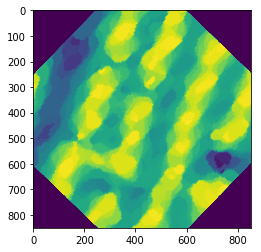

In [97]:
plt.imshow(rotated_img)

In [122]:
custom_filter = np.zeros((9, 9), dtype=np.uint8)
custom_filter[:, 3:6] = 1
custom_filter[:, :3] = -1
custom_filter[:, 6:] = -1

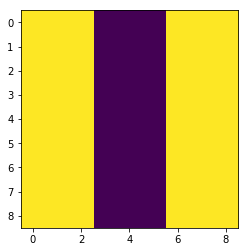

In [123]:
plt.imshow(custom_filter)

In [124]:
filtered_img = cv2.filter2D(rotated_img, cv2.CV_32F, custom_filter)
filtered_img = filtered_img / 2

In [109]:
filtered_img = cv2.erode(rotated_img, custom_filter, iterations=1)
filtered_img_t = cv2.erode(rotated_img, custom_filter.T, iterations=1)

In [125]:
filtered_img.max()

407011.56

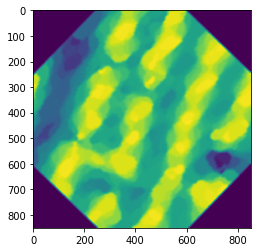

In [127]:
plt.imshow(filtered_img)

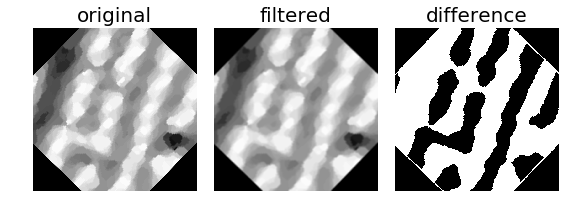

In [129]:
diff = (rotated_img > 45).astype(np.uint8) - (filtered_img > 45).astype(np.uint8)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(rotated_img, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(filtered_img, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('filtered', fontsize=20)

ax[2].imshow(diff, cmap=plt.cm.gray)
ax[2].axis('off')
ax[2].set_title('difference', fontsize=20)

fig.tight_layout()

In [166]:
res.dtype

dtype('uint8')

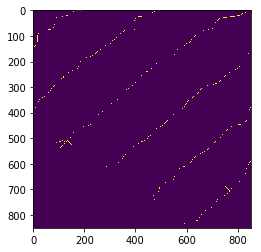

In [159]:
plt.imshow(skelet)

In [124]:
rotated_filter.round().astype(np.uint8)

array([[0, 0, 1, 1, 0],
       [0, 1, 1, 2, 1],
       [1, 1, 2, 1, 1],
       [1, 2, 1, 1, 0],
       [0, 1, 1, 0, 0]], dtype=uint8)

In [28]:
laplacian_filter, grad_angle, result_angle = get_laplacian_filter(skelet.astype(np.uint8).copy())
#print(result_angle[0,0])
filtered_img = cv2.filter2D(res, cv2.CV_32F, rotated_filter)
# filtered_img = cv2.erode(res,rotated_filter.round().astype(np.uint8),iterations = 5)
filtered_img[filtered_img < 0] =0
filtered_img = (filtered_img).astype(np.uint8)

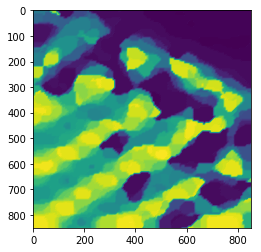

In [29]:
plt.imshow(filtered_img)

In [243]:
rotated_filter

array([[ 0.1640625 , -0.2734375 , -0.25      ,  0.90625   ,  0.1875    ],
       [-0.453125  ,  0.9375    , -0.375     , -0.1875    ,  0.875     ],
       [-0.125     , -0.4375    ,  1.        , -0.4375    , -0.125     ],
       [ 0.875     , -0.1875    , -0.375     ,  0.9375    , -0.453125  ],
       [ 0.1875    ,  0.90625   , -0.25      , -0.2734375 ,  0.13671875]],
      dtype=float32)

In [67]:
filtered_img

array([[29, 29, 29, ..., 41, 41, 41],
       [29, 29, 29, ..., 41, 41, 41],
       [29, 29, 29, ..., 41, 41, 41],
       ...,
       [ 0,  0,  0, ..., 40, 40, 40],
       [ 0,  0,  0, ..., 40, 40, 40],
       [ 0,  0,  0, ..., 40, 40, 40]], dtype=uint8)

In [68]:
res

array([[35, 35, 35, ..., 50, 50, 50],
       [35, 35, 35, ..., 50, 50, 50],
       [35, 35, 35, ..., 50, 50, 50],
       ...,
       [ 1,  1,  1, ..., 49, 49, 49],
       [ 1,  1,  1, ..., 49, 49, 49],
       [ 1,  1,  1, ..., 49, 49, 49]], dtype=uint8)

In [22]:
np.mean(grad_angle[(grad_angle >0) & (grad_angle != 90) & (grad_angle != 180)])

53.09019301888721

(array([1.259e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 6.303e+03, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.958e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

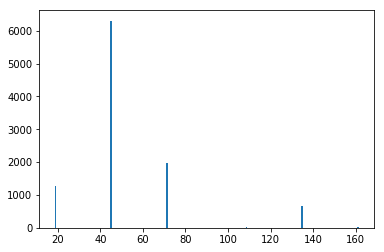

In [23]:
plt.hist(grad_angle[(grad_angle >0) & (grad_angle != 90) & (grad_angle != 180)], bins=180)

In [24]:
np.bincount(grad_angle[grad_angle> 0].flatten().astype(np.uint8))

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0, 1259,    0,    0,    0,
          0,    0,    0,    0,    4,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       6303,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 1958,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0, 1369,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,   38,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,  674,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

44

In [26]:
for c, u in zip(counts, unique):
    print(u, c)

18 1259
26 4
44 6303
71 1958
90 1369
108 38
135 674
161 12
180 337


In [27]:
unique

array([ 18,  26,  44,  71,  90, 108, 135, 161, 180], dtype=uint8)

In [28]:
np.median(grad_angle[grad_angle > 0])

44.990455627441406

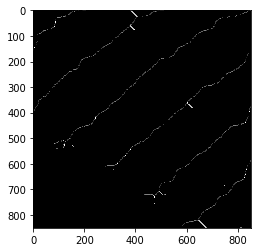

In [29]:
plt.imshow(grad_angle, 'gray')

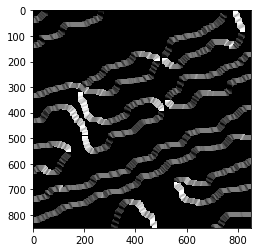

In [125]:
plt.imshow(grad_angle, 'gray')

In [ ]:
laplaccian_filter

In [ ]:
test_arr = np.array([[1, 3, 4, 4],
          [1, 3, 4, 4],
          [0, 3, 4, 4], 
          [0, 3, 4, 4]], dtype=np.float32)

In [ ]:
filtered_test = cv2.filter2D(test_arr, cv2.CV_32F, laplaccian_filter)

In [ ]:
plt.imshow(filtered_test)

In [ ]:
plt.imshow(test_arr)

In [ ]:
filtered_img.max()